In [1]:
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from matplotlib import pyplot as plt
import math
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer, transpile
from scipy.optimize import minimize
import torch
from torch import Tensor
from torch.optim import Adam, LBFGS
from torch.nn import MSELoss
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.algorithms.optimizers import ADAM

backend=Aer.get_backend('qasm_simulator')

In [2]:
class DQCSolver:
    def __init__(self, qubit, depth, backend, input, Lambda, kappa):
        self.featuremap=self.ChebyshevTower
        self.plus=np.pi/2
        self.minus=-np.pi/2
        self.qubit=qubit
        self.depth=depth
        self.init=np.random.uniform(0,2*np.pi,self.qubit*self.depth*3)
        self.backend=backend
        self.input=input
        self.Lambda=Lambda
        self.kappa=kappa
        self.lossvalue = list()
        self.trueloss=list()
    def qcirc(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        quantumcircuit=QuantumCircuit(qr,cr)
        return quantumcircuit
    def measure(self, circuit):
        for i in range(circuit.num_qubits):
            circuit.measure(i,i)
    # featuremap
    def ProductFeatureMap(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x, i)
        bc=qc.bind_parameters({x:math.asin(input)})
        return bc
    def Chebyshev(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def ChebyshevTower(self, input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry((i)*x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def circuit_expectation(self,counts):
        exp=[]
        for i in range(self.qubit):
            for j, k in counts.items():
                prob=(k/self.backend.options.shots)**2
                if j[i]=='0':
                    eigenvalue=1
                if j[i]=='1':
                    eigenvalue=-1
                exp.append(eigenvalue*prob)
        expectation=sum(exp)
        return expectation
###################################################################
    def FmAnsatz(self, qc, theta):
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+self.qubit*d)],i)
                qc.rx(theta[3*(i+self.qubit*d)+1],i)
                qc.rz(theta[3*(i+self.qubit*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc
    def f(self, input, theta): 
        fm=self.featuremap(input)
        fm_ansatz=self.FmAnsatz(fm,theta)
        fm_ansatz.barrier()
        self.measure(fm_ansatz)
        counts=self.backend.run(transpile(fm_ansatz, self.backend),shots=2000).result().get_counts()
        fx=self.circuit_expectation(counts) 
        return fx
    def CTfeaturemap_plus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.plus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CTfeaturemap_minus(self, order, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x*i+self.minus, i)
            if i!=order:
                qc.ry(x*i,i)
        qc=qc.bind_parameters({x:2*math.acos(input)})
        return qc
    def CT_qnn_plus(self, order, input, theta):
        fm=self.CTfeaturemap_plus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_qnn_minus(self, order, input, theta):
        fm=self.CTfeaturemap_minus(order=order, input=input)
        fm_ansatz=self.FmAnsatz(qc=fm, theta=theta)
        return fm_ansatz
    def CT_dfdx(self, input, theta):
        j_expectation_list=[]
        for j in range(self.qubit):
            j_expectation=self.CT_qnn_plus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            plus_exp=self.circuit_expectation(counts)
            j_expectation=self.CT_qnn_minus(order=j, input=input, theta=theta)
            j_expectation.barrier()
            self.measure(j_expectation)
            counts=self.backend.run(transpile(j_expectation, self.backend),shots=2000).result().get_counts()
            minus_exp=self.circuit_expectation(counts)
            j_expectation_list.append(0.25*(-2*j)/np.sqrt(1-input**2)*(plus_exp-minus_exp))
        return sum(j_expectation_list)
#########################################################################################
    # loss
    def MSE(self,a,b):
            mean_square_error=(a-b)**2
            return mean_square_error
    def loss(self, theta):
            loss_list=[]
            for x_i in self.input:
                fx_i=self.f(input= x_i, theta=theta)
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/len(self.input)
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def b_loss(self, theta):
            loss_list=[]
            fb=1-self.f(input=self.input[0], theta=theta)
            input_x0=np.delete(self.input, 0)
            for x_i in input_x0:
                fx_i=self.f(input= x_i, theta=theta)+fb
                fprimex_i=self.CT_dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/(len(input_x0))
            self.lossvalue.append(total_loss)
            print(total_loss)
            return total_loss
    def b_solve(self, maxiter, tol, lr, theta):
        adam=ADAM(maxiter=maxiter, tol=tol, lr=lr)
        if theta is None:
            result=adam.minimize(fun=self.b_loss, x0=self.init)
        elif theta is not None:
            result=adam.minimize(fun=self.b_loss, x0=theta)
        for i in range(len(self.lossvalue)):
            if i % (self.qubit*self.depth*3)==0:
                self.trueloss.append(self.lossvalue[i])
        solution_theta=result.x
        input_x0=np.delete(self.input,0)
        fx=[1]
        for i in input_x0:
            fxi=self.f(input=i,theta=solution_theta)
            fx.append(fxi)
        ux=[]
        for i in self.input:
            uxi=np.exp((-1)*self.kappa*self.Lambda*i)*np.cos(self.Lambda*i)
            ux.append(uxi)
        plt.subplot(211)
        plt.plot(self.input, fx)
        plt.plot(self.input, ux,'r')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        x_iter=list(range(1, maxiter+2))
        plt.subplot(212)
        plt.plot(x_iter, self.trueloss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        return result

In [8]:
dqc63_2nd=DQCSolver(qubit=6, depth=3, backend=backend, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result63_2nd=dqc63_2nd.b_solve(maxiter=50, tol=1e-7, lr=0.01, theta=result63.x)

1320.5249897935723
1304.2795080785872
1301.4257109318905
1315.9013133831784
1339.5016992453425
1305.4156700176
1310.8800809814036
1172.1015344088225
1389.7765584503843
1302.2476748080364
1377.6523024134758
1431.6272994365727
1272.9399033513425
1248.7365980301322
1225.0242721450238
1280.5583342285033
1257.587852337104
1364.464282755032
1294.5233350649848
1390.0139842970632
1312.1026612531268
1278.983676406032
1360.9759556540382
1332.4691123141874
1341.4810241929283
1211.9820946091775
1289.664322154027
1327.8060385628282
1314.4858734068023
1234.4937104240696
1306.3501661581138
1297.2966964081595
1181.1949006300279
1417.5985294695006
1277.9895254539945
1235.393193919857
1260.7182557417575
1363.321700332543
1319.427878882177
1305.375661715977
1273.0582046244108
1304.9645837130738
1225.9849265090204
1257.2868885996193
1254.4525193767204
1326.4821308799646
1337.3136015943894
1346.6627756521982
1291.1471978884456
1233.216613590098
1290.8621649269244
1219.1865727112763
1295.7258972789411
1360.

1562.325734178529
1526.2320385993205
1515.1166163402224
1475.2348354475012
1550.4990532123977
1474.7589453435849
1589.5287633312528
1603.8682372955705
1559.2551470061894
1565.2648228099831
1575.3458422665858
1491.0057251015462
1519.101747059092
1546.3931692502636
1451.6836572615143
1446.514012871284
1466.5664781803503
1482.4736044739452
1653.2896229312469
1464.4987043100457
1490.8202282076447
1490.4393678654005
1597.4965383101244
1520.5990503642608
1533.9874984252153
1550.571524241046
1496.3894580312242
1455.6797092824982
1535.5430518112607
1541.3118939134486
1512.065426016562
1522.2305479989027
1607.3589114869594
1484.7789456866612
1432.0423615553448
1537.0065535268168
1530.9081127989082
1532.1180183766726
1559.6940570134655
1510.9203183815962
1496.7520069864706
1476.629243281564
1549.9430126874229
1507.9515235224158
1483.4178349677557
1625.274674034056
1514.6310072409178
1556.0576972314182
1584.9502654779078
1404.8812769859712
1471.5763754890763
1493.3757391670133
1591.7985565534054


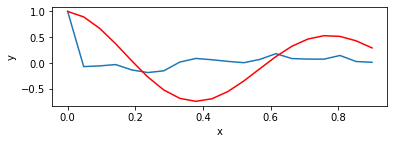

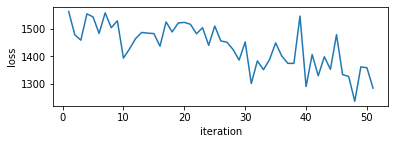

In [ ]:
dqc63=DQCSolver(qubit=6, depth=3, backend=backend, input=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
result63=dqc63.b_solve(maxiter=50, tol=1e-7, lr=0.01, theta=None)

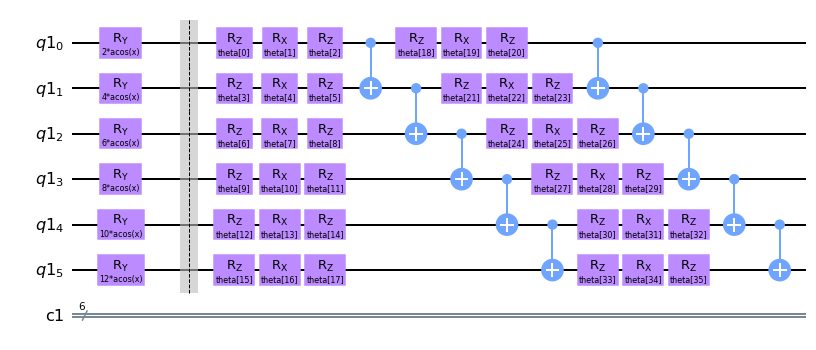

In [6]:
qnn[0].draw('mpl')

In [89]:
estimator_qnn=EstimatorQNN(
                circuit=qnn[0],
                input_params=qnn[1].parameters,
                weight_params=qnn[2].params
)

In [90]:
model=TorchConnector(estimator_qnn, initial_weights=np.random.uniform(0,2*np.pi,36))

In [91]:
optimizer=ADAM(model.parameters())

In [92]:
f_loss=MSELoss(reduction='mean')

In [93]:
model.train()

TorchConnector()

In [96]:
model(x[0,:])

QiskitMachineLearningError: 'Estimator job failed.'

In [64]:
x[0,:]

tensor([0.])

In [95]:
x=torch.linspace(0,0.9,20).reshape(20,1)
x


tensor([[0.0000],
        [0.0474],
        [0.0947],
        [0.1421],
        [0.1895],
        [0.2368],
        [0.2842],
        [0.3316],
        [0.3789],
        [0.4263],
        [0.4737],
        [0.5211],
        [0.5684],
        [0.6158],
        [0.6632],
        [0.7105],
        [0.7579],
        [0.8053],
        [0.8526],
        [0.9000]])

In [68]:
a

tensor([[10]])

In [79]:
optimizer = LBFGS(model.parameters())
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model(x[0]),a) # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss



# Run optimizer step4
optimizer.step(closure)

RuntimeError: Found dtype Long but expected Float

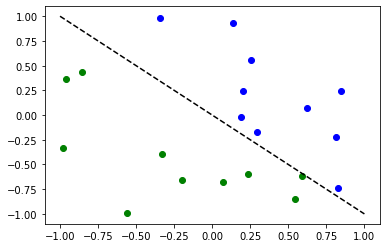

In [45]:
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


In [46]:
X_

tensor([[-0.5588, -0.9909],
        [ 0.2517,  0.5529],
        [ 0.2383, -0.5968],
        [ 0.6204,  0.0766],
        [ 0.8130, -0.2233],
        [-0.8531,  0.4389],
        [-0.9610,  0.3624],
        [-0.1963, -0.6542],
        [ 0.5453, -0.8498],
        [ 0.1382,  0.9292],
        [-0.9815, -0.3314],
        [ 0.8477,  0.2444],
        [ 0.0678, -0.6746],
        [-0.3438,  0.9811],
        [ 0.1991,  0.2454],
        [ 0.1912, -0.0197],
        [ 0.2917, -0.1674],
        [ 0.8296, -0.7351],
        [ 0.5871, -0.6114],
        [-0.3318, -0.3937]])

In [47]:

y_

tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]])

In [78]:
a=torch.tensor([10])
a

tensor([10])

In [18]:
a=np.linspace(0,0.9,20)

In [31]:
for i in x:
    print(model(i))


tensor([0.0002], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0021], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0041], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0060], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0080], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0099], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0118], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0136], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0155], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0173], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0190], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0207], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0224], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0240], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0256], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0271], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0286], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0300], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0313], grad_fn=<_TorchNNFunctionBack

In [20]:
model(a)


tensor([[-0.0223]], grad_fn=<_TorchNNFunctionBackward>)

In [70]:

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw("mpl")
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [ 0.05479121 -0.01222431  0.07171958  0.03947361 -0.08116453  0.09512447
  0.05222794  0.05721286]


In [71]:
model1(X_[0, :])

tensor([-0.3833], grad_fn=<_TorchNNFunctionBackward>)

In [73]:
model1(X_)

tensor([[-0.3833],
        [-0.3797],
        [-0.3408],
        [-0.9776],
        [-0.8967],
        [-0.5416],
        [-0.5930],
        [ 0.1336],
        [ 0.1328],
        [-0.3805],
        [-0.8122],
        [ 0.5893],
        [-0.1411],
        [ 0.3003],
        [-0.0901],
        [ 0.9564],
        [ 0.8928],
        [ 0.0773],
        [ 0.2459],
        [ 0.4743]], grad_fn=<_TorchNNFunctionBackward>)

In [72]:
y_

tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]])

In [18]:
solver_adam2=dqc(qubit=6,depth=3, backend=backend, x=np.linspace(0,0.9,20),Lambda=8, kappa=0.1)
init=np.random.uniform(0, 2*np.pi, 54)
adam2=ADAM(maxiter=100, tol=1e-7, lr=0.001)
adam2.minimize(fun=solver_adam2.loss, x0=init)

2.4222554692661276
2.5469252423029514
2.804020774974529
4.015323934527976
2.044170737724193
3.37760721122377
2.0073335795209952
3.046021103921232
2.75085597946837
3.36747679000081
2.869655599289389
3.326092137219883
2.30139754383412
3.117456918284689
3.6017887336799737
2.1177874507722603
1.8079464626447
2.823475516909214
3.123538482724249
3.35220699829413
1.9932445615301373
1.4768829422846237
1.5980231343849447
1.504698205252818
2.096650048589392
2.3914927414370224
3.2342243557410013
2.1221471015986486
2.8102389596013095
3.434005183977302
2.139496698120595
3.536729665139542
2.2539028198759654
2.814963026912578
2.946266538390708
2.164840003139643
3.353552934457098
2.7478212119621928
2.6056397049168263
2.9525460387993734
1.9701824717533243
3.022589644410249
3.7115192065952143
1.3743440100443496
2.7576675740531162
2.458414565324246
2.584694700805796
2.533060686169194
2.7165959678416725
1.424425562880046
2.7871678024905733
2.268203208329552
2.683797237928529
2.9193568168296977
2.0434382267

KeyboardInterrupt: 

In [41]:
adam=ADAM(maxiter=200, tol=1e-7, lr=0.001)
adam.minimize(fun=loss_adam, x0=np.random.uniform(0,2*np.pi, 45))


5.92456172433208
6.2417484306114694
5.819867054885226
7.793085432755353
11.034990162697897
7.432654871262531
6.155831820001785
8.19295101017208
10.178391291850197
5.001247151465394
5.859091706173144
9.389324380984016
3.5763557879777963
7.049290140380187
6.844995585548075
9.103227146107141
8.429055353671044
7.8675633005673875
5.821646521434461
8.090260125655279
5.5793432931213705
6.602060508256583
6.669436293940201
6.144008072573036
8.226047460369335
7.87791424974567
7.088565675678609
8.058626441344233
7.657730962277711
6.758147702969052
6.004514346258157
6.0760286676804025
5.401362666658928
11.43555670192914
8.457482911005842
8.199120189275849
10.020964155532553
6.137593924425042
8.510915500467492
9.111857088520727
5.158181997338948
5.925234359329644
8.016427521499367
7.026430578557852
5.52797191814898
4.545321283512449
7.599652270523153
7.896146583309642
7.152392983231157
5.3459416768276515
5.760208637490512
6.5144712222367875
7.575429783432743
11.422030763464848
7.177079654555378
9.3